In [5]:
!pip install --upgrade pip
!pip install ray
!pip install -U ipywidgets
!pip install "ray[default]"

Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^


In [6]:
import ray

ray.shutdown()
ray.init()  # Start local Ray cluster

@ray.remote
class Counter:
    def __init__(self):
        self.count = 0

    def increment(self):
        self.count += 1
        return self.count

counter = Counter.remote()
print(ray.get(counter.increment.remote()))  # prints 1
print(ray.get(counter.increment.remote()))  # prints 2
ray.shutdown()


2025-08-02 07:01:52,204	INFO worker.py:1918 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


1
2


In [20]:
%%writefile decentralized_sgd.py
import ray
import torch
import matplotlib.pyplot as plt

ray.shutdown()
ray.init(include_dashboard=True, num_cpus=10)

@ray.remote
class Worker:
    def __init__(self, id, X, y):
        self.id = id
        self.X = X
        self.y = y
        self.neighbors = []
        self.w = torch.randn(2, requires_grad=False)
        self.lr = 0.1
        self.received_weights = []

    def set_neighbors(self, neighbors):
        self.neighbors = neighbors
        self.received_weights = [self.w for _ in neighbors]  # Initialize with own weights

    def sgd_step(self):
        y_hat = self.X @ self.w
        grad = 2 * (y_hat - self.y) @ self.X / len(self.y)
        self.w = self.w - self.lr * grad

    def send_weights(self):
        futures = []
        for i, neighbor in enumerate(self.neighbors):
            futures.append(neighbor.receive_weights.remote(self.w, self.id))
        return futures

    def receive_weights(self, w, sender_id):
        idx = sender_id % len(self.neighbors)
        self.received_weights[idx] = w
        return True

    def update_weights(self):
        all_ws = [self.w] + self.received_weights
        self.w = sum(all_ws) / len(all_ws)

    def get_param(self):
        return self.w

    def compute_loss(self):
        y_hat = self.X @ self.w
        return torch.mean((y_hat - self.y) ** 2).item()

def main():
    N = 100
    x = torch.linspace(-1, 1, N).unsqueeze(1)
    true_w = torch.tensor([2.0, -3.0])
    X = torch.cat([x, torch.ones_like(x)], dim=1)
    y = X @ true_w + 0.1 * torch.randn(N)

    cpus = int(ray.available_resources().get('CPU', 1))
    print(f"Using {cpus} workers (CPUs available: {ray.available_resources().get('CPU', 1)})")

    parts = torch.chunk(X, cpus)
    labels = torch.chunk(y, cpus)

    workers = [Worker.remote(i, parts[i], labels[i]) for i in range(cpus)]

    for i, worker in enumerate(workers):
        neighbors = [workers[(i + 1) % len(workers)]]  # simple ring topology
        ray.get(worker.set_neighbors.remote(neighbors))

    # Store history for plotting: weights and losses per worker per step
    weights_history = [[] for _ in range(cpus)]
    loss_history = [[] for _ in range(cpus)]

    for step in range(100):
        ray.get([w.sgd_step.remote() for w in workers])
        futures_lists = ray.get([w.send_weights.remote() for w in workers])
        all_futures = [fut for sublist in futures_lists for fut in sublist]
        ray.get(all_futures)
        ray.get([w.update_weights.remote() for w in workers])

        # Record weights and loss for each worker at this step
        ws = ray.get([w.get_param.remote() for w in workers])
        losses = ray.get([w.compute_loss.remote() for w in workers])
        for i in range(cpus):
            weights_history[i].append(ws[i].numpy())
            loss_history[i].append(losses[i])

        if step % 10 == 0:
            print(f"Step {step} weights:")
            for i, w in enumerate(ws):
                print(f"  Worker {i}: {w.numpy()}")

    # After loop: Plot convergence of each worker's weights and loss
    import numpy as np
    steps = np.arange(100)

    plt.figure(figsize=(14, 6))

    # Plot weight components for each worker
    plt.subplot(1, 2, 1)
    for i in range(cpus):
        w_arr = np.array(weights_history[i])
        plt.plot(steps, w_arr[:, 0], label=f'Worker {i} weight 0')
        plt.plot(steps, w_arr[:, 1], label=f'Worker {i} weight 1', linestyle='--')
    plt.xlabel('Step')
    plt.ylabel('Weight values')
    plt.title('Weights convergence per worker')
    plt.legend(fontsize='small')

    # Plot loss per worker
    plt.subplot(1, 2, 2)
    for i in range(cpus):
        plt.plot(steps, loss_history[i], label=f'Worker {i}')
    plt.xlabel('Step')
    plt.ylabel('MSE Loss')
    plt.title('Loss convergence per worker')
    plt.legend(fontsize='small')

    plt.tight_layout()
    plt.savefig("decentralized_sgd_convergence.png")
    print("Plot saved to decentralized_sgd_convergence.png")
    
if __name__ == "__main__":
    main()
    ray.shutdown()


Overwriting decentralized_sgd.py


In [21]:
!python3.10 decentralized_sgd.py

2025-08-02 07:10:13,597	INFO worker.py:1918 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
Using 10 workers (CPUs available: 10.0)
Step 0 weights:
  Worker 0: [-0.49722135 -0.297817  ]
  Worker 1: [ 0.13047354 -1.7675483 ]
  Worker 2: [ 0.63649786 -1.4640639 ]
  Worker 3: [ 0.76779747 -0.70096684]
  Worker 4: [0.5338901  0.06448084]
  Worker 5: [-0.15043846 -0.08988094]
  Worker 6: [-1.1012657  -0.02474561]
  Worker 7: [-0.7363816  -0.02389696]
  Worker 8: [-0.0944532   0.22249031]
  Worker 9: [-0.53400326  1.0826378 ]
Step 10 weights:
  Worker 0: [ 0.4162507 -1.9198916]
  Worker 1: [ 0.8808339 -2.528458 ]
  Worker 2: [ 1.100388  -2.8066187]
  Worker 3: [ 1.2406356 -2.900956 ]
  Worker 4: [ 1.2991588 -2.9219673]
  Worker 5: [ 1.2521274 -2.9094937]
  Worker 6: [ 1.1251143 -2.81817  ]
  Worker 7: [ 0.9332118 -2.6151617]
  Worker 8: [ 0.64165163 -2.2849643 ]
  Worker 9: [ 0.2757547 -1.7975427]
Step 20 weights:
  Worker 0: [ 1.5092055 -2.7312496]
  Worker 1: [ 1.637

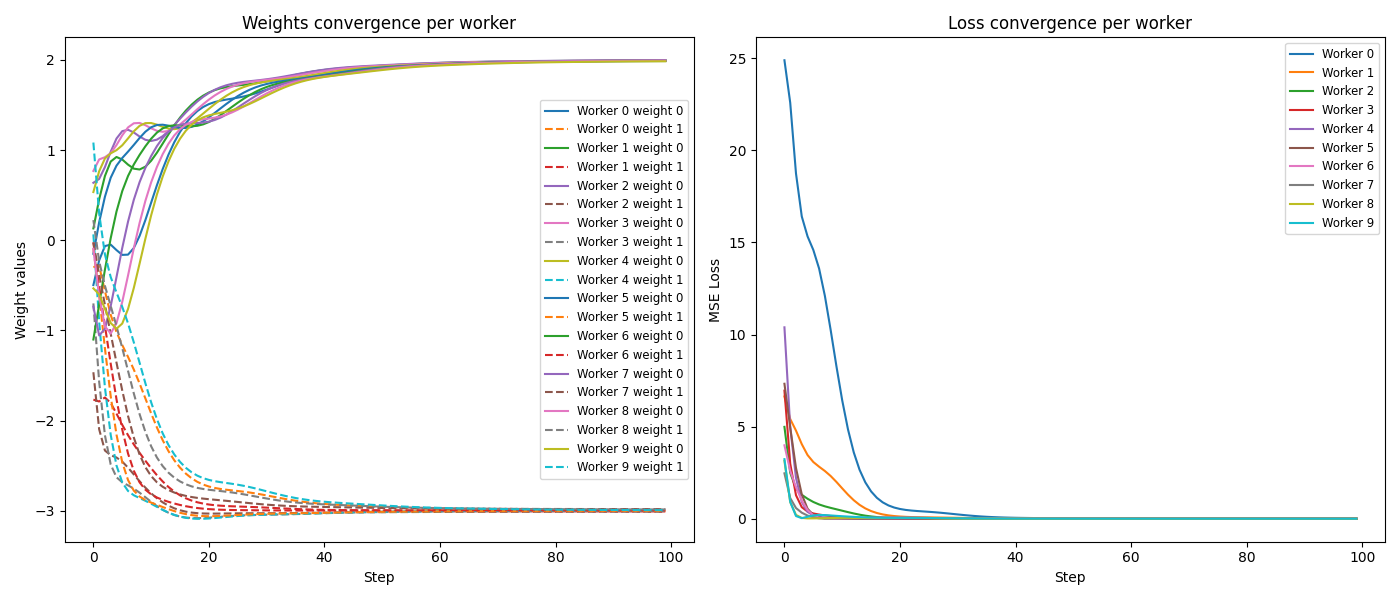

In [22]:
#load and show decentralized_sgd_convergence
from IPython.display import Image, display
display(Image(filename='decentralized_sgd_convergence.png'))


In [5]:
%%writefile decentralized_sgd_plots.py
import ray
import torch
import matplotlib.pyplot as plt
import os

ray.shutdown()
ray.init(include_dashboard=False, num_cpus=10)

@ray.remote
class Worker:
    def __init__(self, id, X, y):
        self.id = id
        self.X = X
        self.y = y
        self.neighbors = []
        self.w = torch.randn(2, requires_grad=False)
        self.lr = 0.1
        self.received_weights = []

    def set_neighbors(self, neighbors):
        self.neighbors = neighbors
        self.received_weights = [self.w for _ in neighbors]

    def sgd_step(self):
        y_hat = self.X @ self.w
        grad = 2 * (y_hat - self.y) @ self.X / len(self.y)
        self.w = self.w - self.lr * grad

    def send_weights(self):
        futures = []
        for i, neighbor in enumerate(self.neighbors):
            futures.append(neighbor.receive_weights.remote(self.w, self.id))
        return futures

    def receive_weights(self, w, sender_id):
        if len(self.neighbors) == 0:
            return True
        idx = sender_id % len(self.neighbors)
        self.received_weights[idx] = w
        return True

    def update_weights(self):
        all_ws = [self.w] + self.received_weights
        self.w = sum(all_ws) / len(all_ws)

    def get_param(self):
        return self.w

    def get_loss(self):
        y_hat = self.X @ self.w
        loss = torch.mean((y_hat - self.y) ** 2).item()
        return loss

def get_neighbors(workers, topology):
    N = len(workers)
    neighbors_list = []
    if topology == 'line':
        for i in range(N):
            if i < N-1:
                neighbors_list.append([workers[i+1]])
            else:
                neighbors_list.append([])
    elif topology == 'ring':
        for i in range(N):
            neighbors_list.append([workers[(i + 1) % N]])
    elif topology == 'fully_connected':
        for i in range(N):
            neighbors = [workers[j] for j in range(N) if j != i]
            neighbors_list.append(neighbors)
    else:
        raise ValueError("Unknown topology")
    return neighbors_list

def run_experiment(topology, seed, save_dir):
    torch.manual_seed(seed)
    N = 1000
    x = torch.linspace(-1, 1, N).unsqueeze(1)
    true_w = torch.tensor([2.0, -3.0])
    X = torch.cat([x, torch.ones_like(x)], dim=1)
    y = X @ true_w + 0.1 * torch.randn(N)

    cpus = min(10, int(ray.available_resources().get('CPU', 1)))
    parts = torch.chunk(X, cpus)
    labels = torch.chunk(y, cpus)

    workers = [Worker.remote(i, parts[i], labels[i]) for i in range(cpus)]

    neighbors_list = get_neighbors(workers, topology)

    for worker, neighbors in zip(workers, neighbors_list):
        ray.get(worker.set_neighbors.remote(neighbors))

    steps = 100
    weights_history = [[] for _ in range(cpus)]
    loss_history = [[] for _ in range(cpus)]

    for step in range(steps):
        ray.get([w.sgd_step.remote() for w in workers])
        futures_lists = ray.get([w.send_weights.remote() for w in workers])
        all_futures = [fut for sublist in futures_lists for fut in sublist]
        ray.get(all_futures)
        ray.get([w.update_weights.remote() for w in workers])

        ws = ray.get([w.get_param.remote() for w in workers])
        ls = ray.get([w.get_loss.remote() for w in workers])

        for i, (w, l) in enumerate(zip(ws, ls)):
            weights_history[i].append(w.numpy().copy())
            loss_history[i].append(l)

    # Convert weights_history to numpy arrays shape (steps, 2)
    weights_np = [torch.tensor(h).numpy() for h in weights_history]

    # Plot weights and losses
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Weight params plot
    for i in range(cpus):
        axes[0].plot([h[0] for h in weights_np[i]], label=f'Worker {i} param 0')
        axes[0].plot([h[1] for h in weights_np[i]], label=f'Worker {i} param 1', linestyle='dashed')
    axes[0].set_title(f'{topology.capitalize()} topology - Weight parameter convergence')
    axes[0].set_ylabel('Weights')
    axes[0].legend(fontsize='small', ncol=2, loc='upper right')

    # Loss plot
    for i in range(cpus):
        axes[1].plot(loss_history[i], label=f'Worker {i}')
    axes[1].set_title(f'{topology.capitalize()} topology - Local Loss convergence')
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('Loss')
    axes[1].legend(fontsize='small', ncol=2, loc='upper right')

    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f'{topology}_convergence.png')
    plt.savefig(filename)
    plt.close(fig)
    print(f"Saved plot to {filename}")

def main():
    save_dir = 'decentralized_sgd_plots'
    topologies = ['line', 'ring', 'fully_connected']

    for topology in topologies:
        run_experiment(topology, seed=42, save_dir=save_dir)

    ray.shutdown()

if __name__ == "__main__":
    main()




Overwriting decentralized_sgd_plots.py


In [6]:
!python3.10 decentralized_sgd_plots.py

2025-08-02 07:18:10,272	INFO worker.py:1927 -- Started a local Ray instance.
/home/nagravision/sdata/ray/decentralized_sgd_plots.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  weights_np = [torch.tensor(h).numpy() for h in weights_history]
Saved plot to decentralized_sgd_plots/line_convergence.png
Saved plot to decentralized_sgd_plots/ring_convergence.png
Saved plot to decentralized_sgd_plots/fully_connected_convergence.png


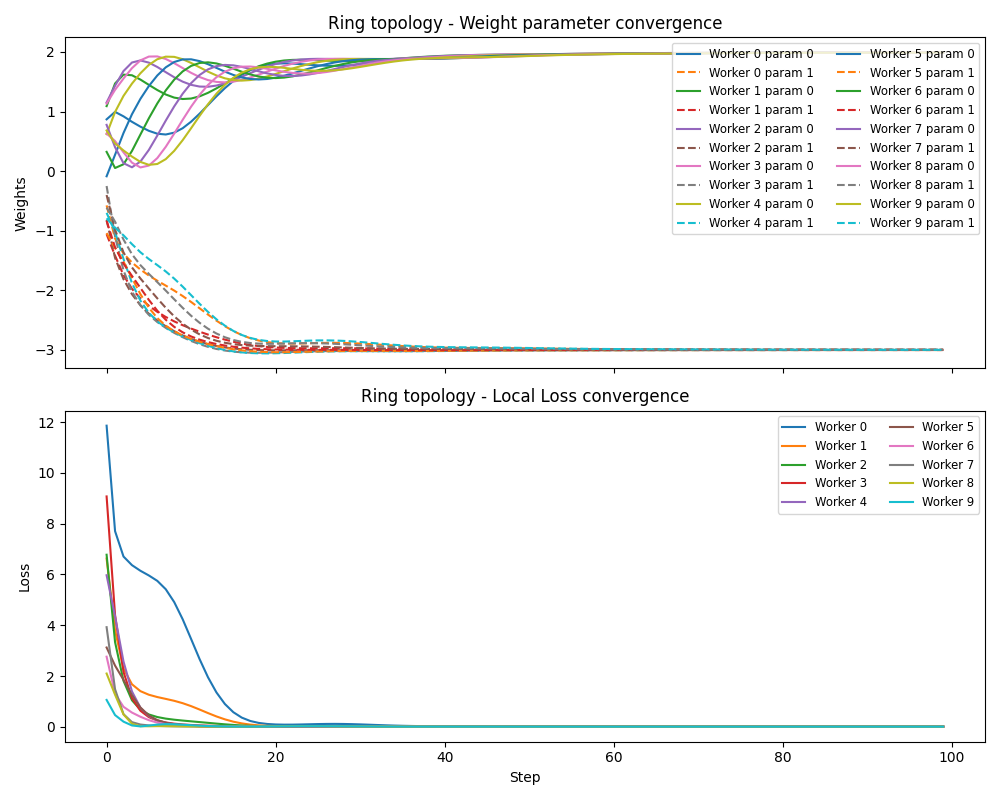

Displayed ring_convergence.png
---


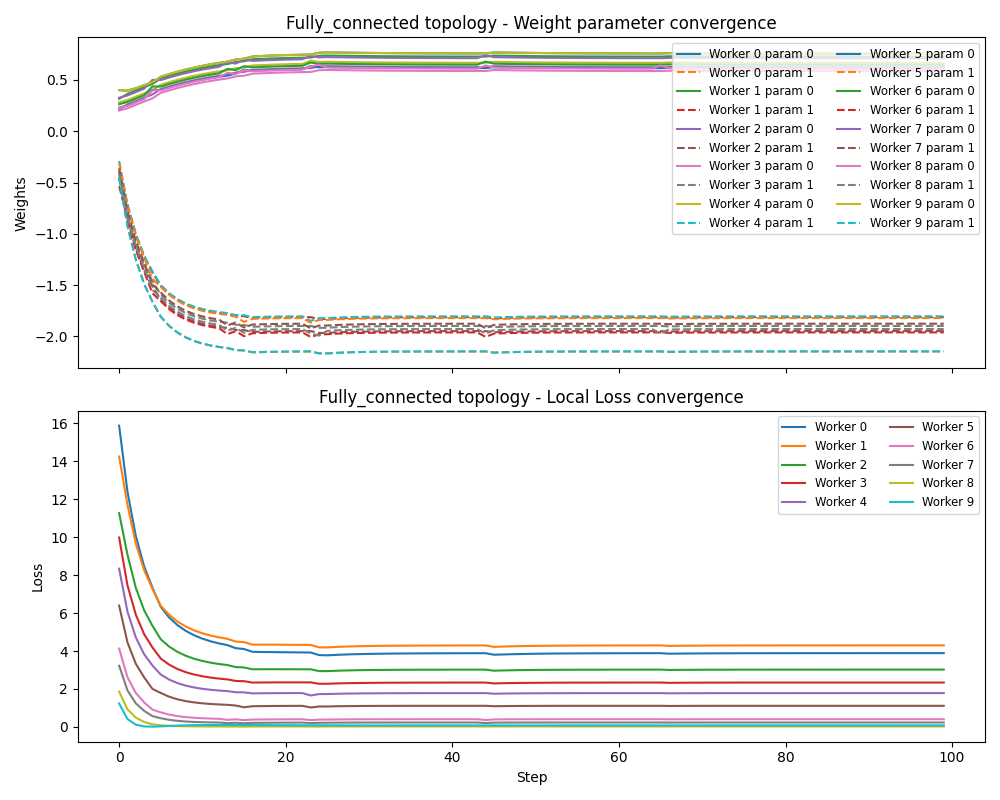

Displayed fully_connected_convergence.png
---


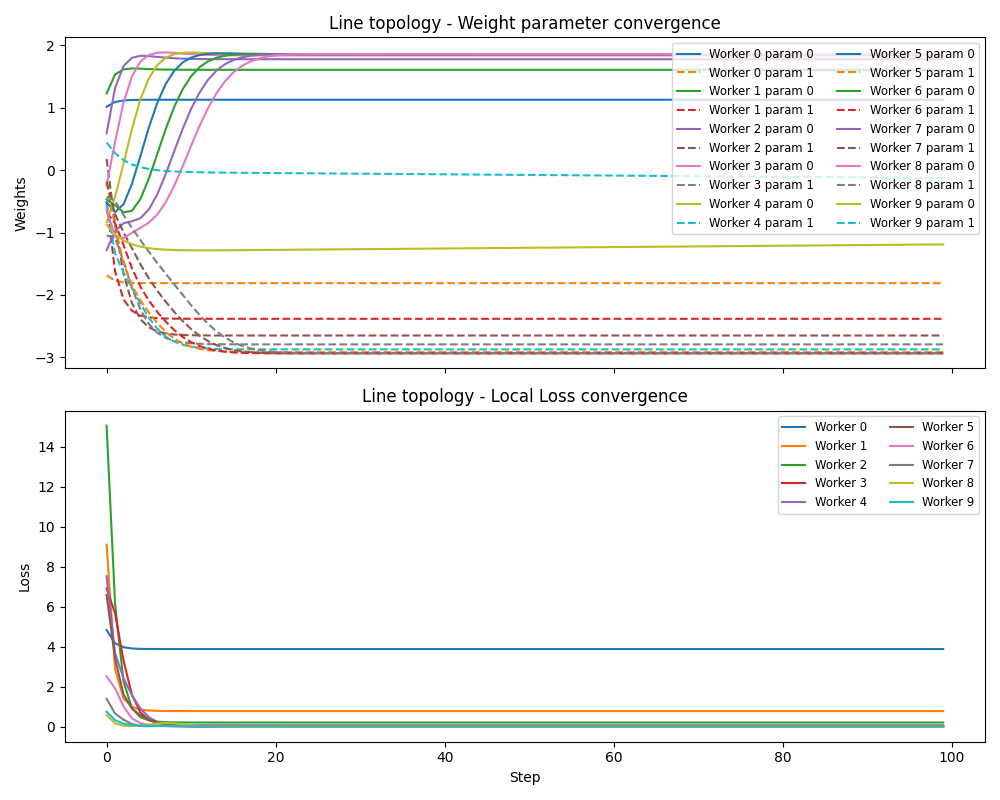

Displayed line_convergence.png
---


In [8]:
# lot all decentralized_sgd_plots in 3 row and 2 cols
from IPython.display import Image, display
import os
save_dir = 'decentralized_sgd_plots'
for filename in os.listdir(save_dir):
    if filename.endswith('.png'):
        display(Image(filename=os.path.join(save_dir, filename)))
        print(f"Displayed {filename}")
        print("---")
